In [1]:
import numpy as np
import pandas as pd
from networkx.generators import nonisomorphic_trees
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import math
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
from random import random
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
def produce_eigenvalues(k,alpha=0,beta=64):
    delta=beta-alpha
    eigenvalues_list=[2*alpha-beta,alpha,beta,2*beta-alpha]
    for i in range(1,k+1):
        delta = delta/2
        eigenvalues_list[-1] += delta
        eigenvalues_list.append(eigenvalues_list[-1]+delta)
        eigenvalues_list.append(eigenvalues_list[0]-delta)
        eigenvalues_list.sort()
    return np.array(eigenvalues_list)

In [4]:
def next_diamater(T_0,T_1,edge_weight):

    d = nx.diameter(T_0)
    T = nx.union(T_0,T_1,rename=("", "T1{}".format(d))  )
    T.add_edge("0","T1{}0".format(d),weight=edge_weight)

    return T

In [5]:
def copy_graph(T,delta):
    T_delta = T.copy()
    T_delta.nodes["0"]["weight"]+=delta
    return(T_delta)

In [6]:
def recompute_edges(T,edge_weight):
    T["0"]['T1{}0'.format(max(0,nx.diameter(T)-2))]['weight'] = edge_weight
    return T

In [7]:
def get_ordered_vertices(T,root):
    
    lst=[[root]]
    computed_vertices=[]
    d = int(nx.diameter(T)/2)+1

    for i in range(d):
        new_lst=[]
        for parent in lst[-1]:
            computed_vertices.append(parent)
            

            for child in list(T.neighbors(parent)):
                if child not in computed_vertices:
                    new_lst.append(child)

        lst.append(new_lst)

    return lst

In [8]:
def compute_v0(T,_lambda_,root):

    a = get_ordered_vertices(T,root)
    eigenvalue = - _lambda_
    congruent_T = T.copy()
    d = math.ceil(nx.diameter(congruent_T)/2)

    for vertex in congruent_T.nodes:
        congruent_T.nodes.data()[vertex]['weight']+=eigenvalue

    for i in range(2,d+2):

        previous_level = a[-i+1]

        level = a[-i]

        for vertex in level:
            neighborhood = list(congruent_T.neighbors(vertex))

            if len(neighborhood) >= 1:
                children = list(set(previous_level) & set(neighborhood))
                weights = nx.get_node_attributes(congruent_T,'weight')
                summation = 0
                for child in children:
                    summation += (congruent_T[vertex][child]['weight'])**2/weights[child]
                congruent_T.nodes.data()[vertex]['weight'] -= summation 


    return nx.get_node_attributes(congruent_T,'weight')[root]

In [9]:
def get_subgraphs(T):
    leafs = []
    [leafs.append(vertex[0]) for vertex in T.degree() if vertex[1]==1]

    children=[]
    [children.append(child) for child in T.neighbors("0")]
    sub_root_vertex = []
    subgraph=[]

    d = int(nx.diameter(T)/2)+1
    [sub_root_vertex.append([]) for i in range(d)]
    [subgraph.append(["0"]) for i in range(d)]

    for distance in range(len(children)):
        sub_root_vertex[distance].extend([ children[distance] ])
        for leaf in leafs:
            path = nx.shortest_path(T,source=leaf, target=children[distance])
            if "0" not in path:
                subgraph[distance].extend(path)
        if distance>0:
            subgraph[distance].extend(subgraph[distance-1])
        subgraph[distance] = list(set(subgraph[distance]))
    return subgraph,sub_root_vertex

In [10]:
def compute_eigenvalues(T):
    node_weights = nx.get_node_attributes(T,'weight')
    weights=[]
    for i in node_weights:
        weights.append(node_weights[i])
    weights=np.array(weights)
    A = nx.to_scipy_sparse_array(T).toarray()
    np.fill_diagonal(A,weights)
    return {'matrix':A,'spectrum':np.round(np.linalg.eigh(A)[0],10)}

In [11]:
def rearrange_edges(T,value,subgraph_vertices,free_edges,root=0):

    H =  T.subgraph(subgraph_vertices).copy()

    H.remove_edge(root,free_edges[0])
    S = [H.subgraph(subset).copy() for subset in nx.connected_components(H)]
    for i in range(2):
        if "0" in S[i].nodes:
            H_0 = S[i]
        elif free_edges[0] in S[i].nodes:
            H_1 = S[i]

    a_v0=compute_v0(H_0,value,"0")
    a_v1=compute_v0(H_1,value,free_edges[0])

    edge_weight = ((a_v0*a_v1))**(1/2)
    T["0"][free_edges[0]]['weight'] = edge_weight

    return T

In [12]:
def unfolding_weighted_tree(T,root_of_branch,number_of_copies=0):
    if number_of_copies>0:
        v = nx.shortest_path(T,root_of_branch,0)[1]
        s=number_of_copies
        edge_weight = T[v][root_of_branch]['weight']
        T_aux=T.copy()
        T_aux.remove_node(v)
        branch_nodes = list(nx.shortest_path(T_aux,root_of_branch).keys())
        branchies_copies = T_aux.subgraph(branch_nodes).copy()
        new_subroots = [root_of_branch*100000**l for l in range(s+1)]
        for l in range(s):
            branch_copy = T_aux.subgraph(branch_nodes).copy() 
            mapping_labels = {node:node*100000**(l+1) for node in branch_nodes}
            branch_copy = nx.relabel_nodes(branch_copy, mapping_labels)
            branchies_copies = nx.union(branchies_copies,branch_copy)
        T.remove_nodes_from(branch_nodes)
        T = nx.union(T,branchies_copies)
        for node in new_subroots:
            T.add_edge(v,node,weight=edge_weight/((s+1)**(1/2)))
        return T

In [19]:
def _find_realization_(alpha=0,beta=64,k=2):

    eigenvalues_list=produce_eigenvalues(k,alpha,beta)

    delta=(beta-alpha)/2

    T_beta = nx.Graph()
    T_beta.add_node(0,weight=beta)
    omega_beta = (((beta-alpha)*(beta-alpha)))**(1/2)
    T_beta = next_diamater(T_beta,T_beta,edge_weight=omega_beta)
    
    T_delta = copy_graph(T_beta,delta)
    omega_delta = ((beta+delta-alpha)*(beta-alpha))**(1/2)
    T_delta=recompute_edges(T_delta,edge_weight=omega_delta)

    T_alpha = nx.Graph()
    T_alpha.add_node(0,weight=alpha)
    omega_alpha = (((alpha-beta)*(alpha-beta)))**(1/2)
    T_alpha = next_diamater(T_alpha,T_alpha,edge_weight=omega_alpha)

    T_theta = copy_graph(T_alpha,delta)
    omega_theta = (((alpha+delta-beta)*(alpha-beta)))**(1/2)
    T_theta=recompute_edges(T_theta,edge_weight=omega_theta)

    for i in range(2,k+1):

        print(i)

        delta=delta/2

        a_v0=compute_v0(T_beta,eigenvalues_list[k+1-i],"0")
        a_v1=compute_v0(T_alpha,eigenvalues_list[k+1-i],"0")
        omega_alpha = ((a_v0*a_v1))**(1/2)   
        _T_alpha_ = next_diamater(T_beta,T_alpha,edge_weight=omega_alpha)
        _T_beta_ = next_diamater(T_theta,T_delta,edge_weight=omega_alpha)

        if i >2: 
            _T_alpha_aux_ = _T_alpha_.copy()
            _T_alpha_aux_.remove_node("0")
            _T_beta_aux_ = _T_beta_.copy()
            _T_beta_aux_.remove_node("0")
            eigenlist_alpha = sorted(list(set(list(np.unique(compute_eigenvalues(_T_alpha_)['spectrum']))+list(np.unique(compute_eigenvalues(_T_alpha_aux_)['spectrum'])))))
            list_values[1].insert(0,max(eigenlist_alpha))
            eigenlist_beta = sorted(list(set(list(np.unique(compute_eigenvalues(_T_beta_)['spectrum']))+list(np.unique(compute_eigenvalues(_T_beta_aux_)['spectrum'])))))
            list_values[0].insert(0,min(eigenlist_beta))


        if i==2:
            _T_alpha_aux_ = _T_alpha_.copy()
            _T_alpha_aux_.remove_node("0")
            _T_beta_aux_ = _T_beta_.copy()
            _T_beta_aux_.remove_node("0")
            if i==2:
                eigenlist1 = sorted(list(set(list(np.unique(compute_eigenvalues(_T_alpha_)['spectrum']))+list(np.unique(compute_eigenvalues(_T_alpha_aux_)['spectrum'])))))
                eigenlist2 = sorted(list(set(list(np.unique(compute_eigenvalues(_T_beta_)['spectrum']))+list(np.unique(compute_eigenvalues(_T_beta_aux_)['spectrum'])))))
                k_=int((len(eigenlist1)-1)/2)
                list_values = [[eigenlist2[2*i] for i in range(int(k_/2+1))],[eigenlist1[-2*i-1] for i in range(int(k_/2+1))]]


        list_values[0],list_values[1]=list_values[1],list_values[0]

        _T_theta_ = copy_graph(_T_alpha_,delta)
        values=list_values[0].copy()

        subgraph,sub_root_vertex = get_subgraphs(_T_theta_)
        print('sub',subgraph)
        print('sub_root',sub_root_vertex)

        for j,H in enumerate(subgraph):
            print(j,H)
            _T_theta_ = rearrange_edges(_T_theta_,values[-j-1],H,sub_root_vertex[j],root="0")


        _T_delta_ = copy_graph(_T_beta_,delta)

        values=list_values[1].copy()

        subgraph,sub_root_vertex = get_subgraphs(_T_delta_)
        for j,H in enumerate(subgraph):
            _T_delta_ = rearrange_edges(_T_delta_,values[-j-1],H,sub_root_vertex[j],root="0")


        T_alpha = _T_alpha_
        T_beta = _T_beta_
        T_theta = _T_theta_
        T_delta = _T_delta_
        
    return T_alpha,T_beta

In [14]:
def find_realization(alpha,beta,diameter):
    k=int((diameter+1)/2)
    M1,M2 = _find_realization_(alpha,beta,k)
    M1 = nx.convert_node_labels_to_integers(M1,first_label=0)
    if diameter%2==0:
        M1 = unfolding_weighted_tree(M1,2**(k-1),number_of_copies=1)
        M1 = nx.convert_node_labels_to_integers(M1,first_label=0)
    return M1

In [20]:
M1 = find_realization(alpha=0,beta=32,diameter=16) 

2
sub [['T100', '0'], ['T100', 'T110', '0', 'T11T100']]
sub_root [['T100'], ['T110']]
0 ['T100', '0']
1 ['T100', 'T110', '0', 'T11T100']
3
sub [['T100', '0'], ['T100', 'T110', '0', 'T11T100'], ['T13T110', 'T13T11T100', '0', 'T100', 'T11T100', 'T110', 'T13T100', 'T130']]
sub_root [['T100'], ['T110'], ['T130']]
0 ['T100', '0']
1 ['T100', 'T110', '0', 'T11T100']
2 ['T13T110', 'T13T11T100', '0', 'T100', 'T11T100', 'T110', 'T13T100', 'T130']
4
sub [['T100', '0'], ['T100', 'T110', '0', 'T11T100'], ['T13T110', 'T13T11T100', '0', 'T100', 'T11T100', 'T110', 'T13T100', 'T130'], ['T150', 'T15T13T100', 'T13T110', 'T13T100', 'T15T13T110', 'T13T11T100', '0', 'T15T110', 'T15T13T11T100', 'T100', 'T11T100', 'T110', 'T15T100', 'T15T11T100', 'T15T130', 'T130']]
sub_root [['T100'], ['T110'], ['T130'], ['T150']]
0 ['T100', '0']
1 ['T100', 'T110', '0', 'T11T100']
2 ['T13T110', 'T13T11T100', '0', 'T100', 'T11T100', 'T110', 'T13T100', 'T130']
3 ['T150', 'T15T13T100', 'T13T110', 'T13T100', 'T15T13T110', 'T13T1

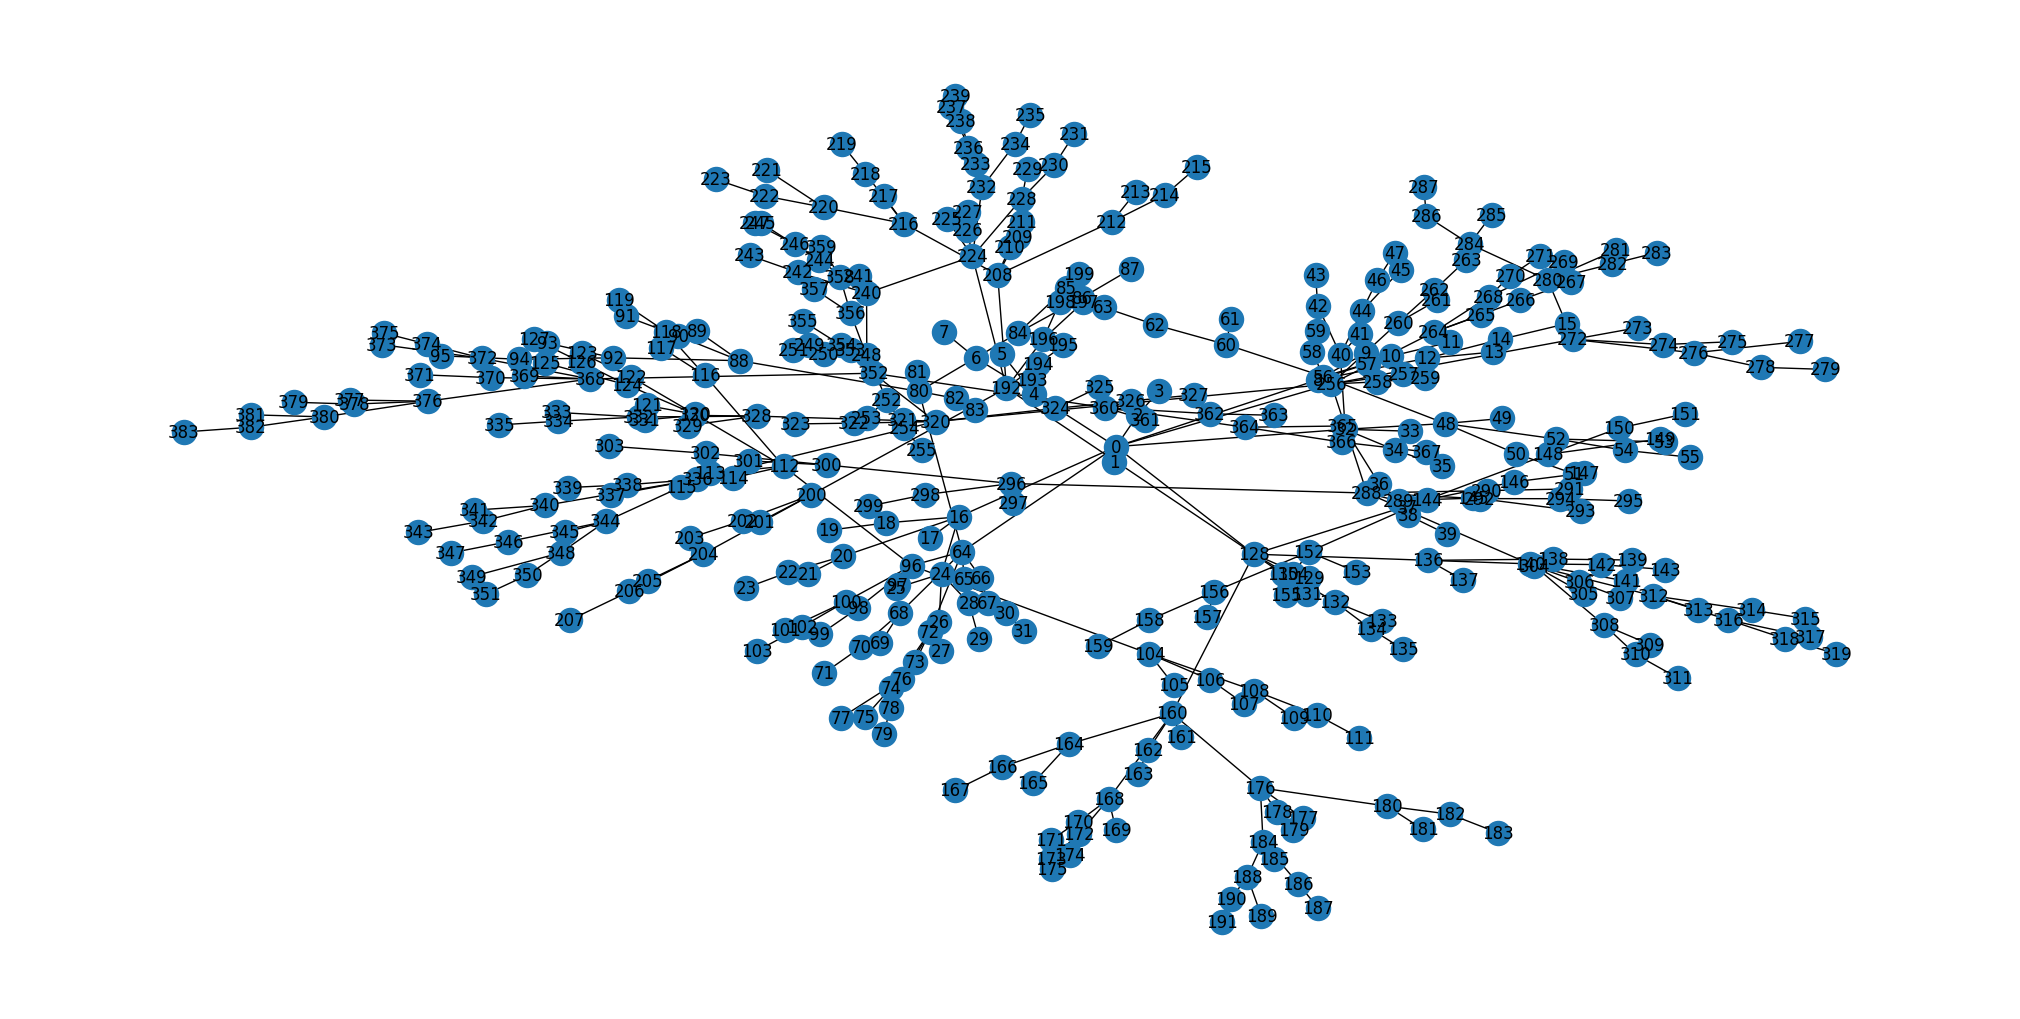

In [22]:
nx.draw(M1,with_labels=True)

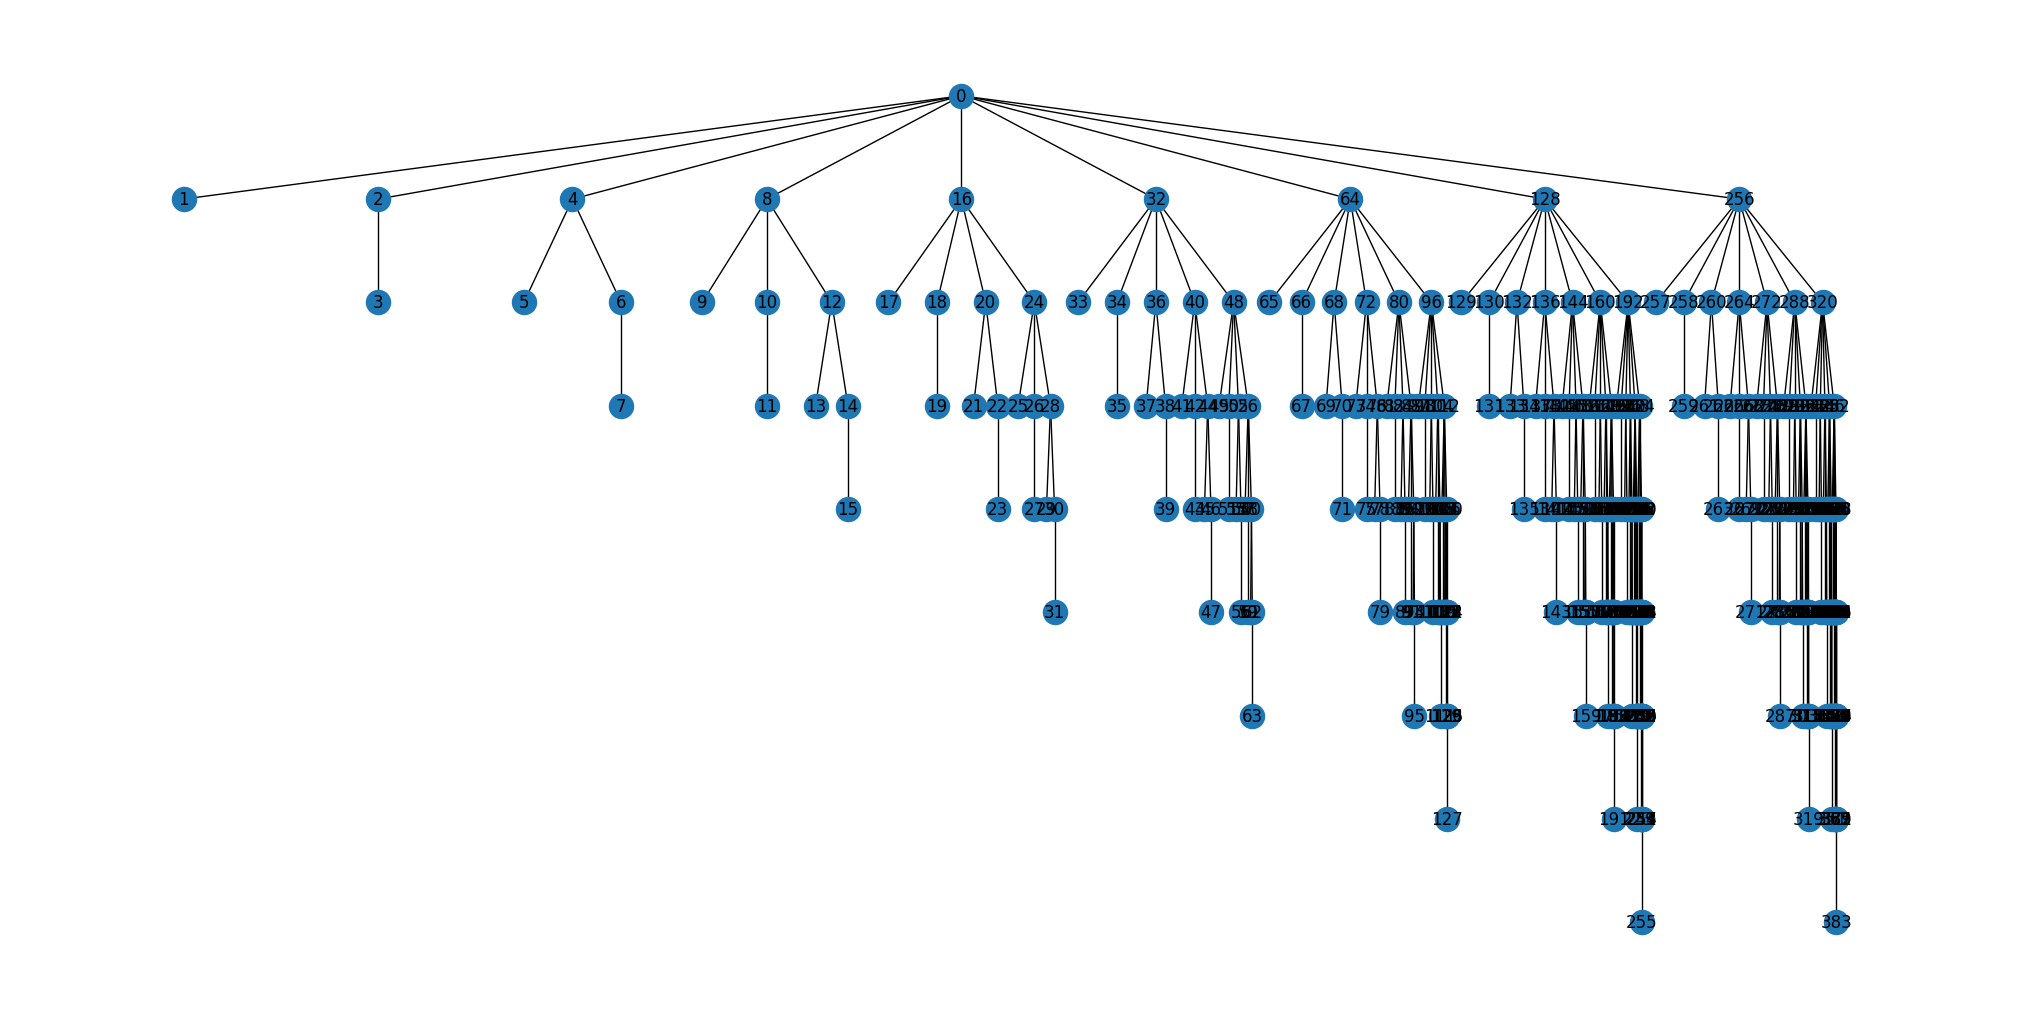

In [23]:
pos = hierarchy_pos(M1,0)
nx.draw(M1,pos=pos,with_labels=True)

In [24]:
compute_eigenvalues(M1)['matrix']

array([[42.5       , 36.87817783, 24.81934729, ...,  0.        ,
         0.        ,  0.        ],
       [36.87817783, 32.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [24.81934729,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 32.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 32.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        32.        ,  0.        ]])

In [25]:
np.unique(compute_eigenvalues(M1)['spectrum'])

array([-63.75, -63.5 , -63.  , -62.  , -60.  , -56.  , -48.  , -32.  ,
         0.  ,  32.  ,  80.  , 104.  , 116.  , 122.  , 125.  , 126.5 ,
       127.25])

In [26]:
compute_eigenvalues(M1)['spectrum']

array([-63.75, -63.5 , -63.  , -62.  , -62.  , -62.  , -60.  , -60.  ,
       -60.  , -60.  , -60.  , -60.  , -56.  , -56.  , -56.  , -56.  ,
       -56.  , -56.  , -56.  , -56.  , -56.  , -56.  , -56.  , -56.  ,
       -48.  , -48.  , -48.  , -48.  , -48.  , -48.  , -48.  , -48.  ,
       -48.  , -48.  , -48.  , -48.  , -48.  , -48.  , -48.  , -48.  ,
       -48.  , -48.  , -48.  , -48.  , -48.  , -48.  , -48.  , -48.  ,
       -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  ,
       -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  ,
       -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  ,
       -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  ,
       -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  ,
       -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  , -32.  ,
        -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,
        -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,  -0.  ,
      